In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from predictables.util import to_pl_lf
from predictables.core.src._UnivariateAnalysis import UnivariateAnalysis
import numpy as np

# load data
df = load_breast_cancer(as_frame=True).frame
df.columns = [c.replace(" ", "_") for c in df.columns]
df["cv"] = np.random.randint(1, 6, df.shape[0])
df = to_pl_lf(df)

df.head().collect()

mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,cv
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0,5
20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,0,4
19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,0,2
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,0,5
20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,0,4


<Axes: >

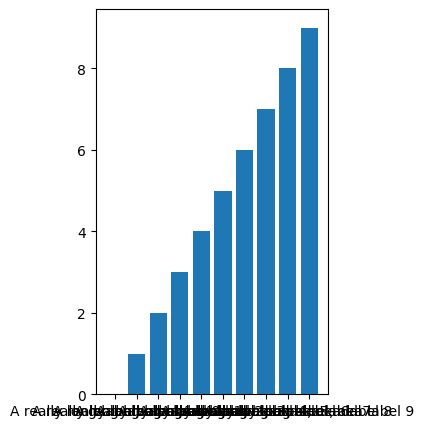

In [2]:
import matplotlib.pyplot as plt


def overlapping_axes():
    # Set up an Axes instance with overlapping labels
    _, ax = plt.subplots(figsize=(3, 5))
    x = [f"A really long label, aka label {i}" for i in range(10)]
    ax.bar(x, range(10))
    return ax


overlapping_axes()

In [2]:
df = pd.read_parquet("./cancerdf.parquet")
df.head()

,comp_1,comp_2,cv,target
0,1160.142186,-293.918296,5,0
1,1269.122238,15.629752,4,0
2,995.793505,39.155983,5,0
3,-407.180613,-67.379945,2,0
4,930.341164,189.340669,3,0


In [6]:
ua = UnivariateAnalysis(
    model_name="model",
    df_train=df,
    df_val=df,
    target_column_name="target",
    feature_column_names=["comp_1", "comp_2"],
    has_time_series_structure=False,
    cv_folds=df["cv"],
)
ua.cv_folds

Performing univariate analysis on 2 features: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


0      5
1      4
2      5
3      2
4      3
      ..
564    2
565    4
566    5
567    3
568    2
Name: cv, Length: 569, dtype: int32

In [2]:
df.collect().shape

(569, 32)

In [3]:
from sklearn.decomposition import PCA

# Specify the number of components for the lower-dimensional subspace
n_components = 2

# Create an instance of PCA
pca = PCA(n_components=n_components)

# Fit the PCA model to the data and transform the data
df_projected = pca.fit_transform(
    df.collect().to_pandas().drop(columns=["cv", "target"])
)

# Convert the projected data into a new dataframe
df_pca = pd.DataFrame(
    df_projected, columns=[f"Component {i+1}" for i in range(n_components)]
)

df_pca["cv"] = df.collect().to_pandas()["cv"]
df_pca["target"] = df.collect().to_pandas()["target"]

df_pca.head()

,Component 1,Component 2,cv,target
0,1160.142574,-293.917544,2,0
1,1269.122443,15.630182,4,0
2,995.793889,39.156743,2,0
3,-407.180803,-67.380320,1,0
4,930.341180,189.340742,4,0


### fit each fold to a model

In [4]:
X, y = (
    df.collect().to_pandas().drop(columns="target"),
    df.select("target").collect().to_pandas()["target"],
)
X.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,cv
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,2
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,4
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,2
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,4


In [5]:
df = df.collect().to_pandas()
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,cv
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,2
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,4
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,2
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,4


In [6]:
from predictables.univariate.src._fit_sm_logistic_regression import (
    fit_sm_logistic_regression,
)
from predictables.core._PredicTables import PredicTables
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

fit_sm_logistic_regression(X_train.iloc[:, :3], y_train)

In [7]:
pt = PredicTables(
    "Cancer Model",
    pd.concat([X_train.iloc[:, :3], y_train], axis=1),
    pd.concat([X_test.iloc[:, :3], y_test], axis=1),
    pd.concat([X_test.iloc[:, :3], y_test], axis=1),
    "target",
    X_train["cv"],
    False,
)
pt.ua.build_report("new_test_report.pdf", max_per_file=5)

Performing univariate analysis on 3 features: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]
Sorting features by their relevance based on an univariate analysis: 100%|██████████| 3/3 [00:00<00:00, 15669.88it/s]
Sorting features by their relevance based on an univariate analysis: 100%|██████████| 3/3 [00:00<00:00, 28276.21it/s]
Building 3 univariate analysis reports: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


In [11]:
pt.ua._sort_features_by_ua().index.tolist()

Sorting features by their relevance based on an univariate analysis: 100%|██████████| 3/3 [00:00<00:00, 17403.75it/s]


['mean_texture', 'mean_radius', 'mean_perimeter']